In [1]:
# !export HF_HOME=$STORE_DIR/huggingface

!export HF_HOME=/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/misc
!export HF_DATASETS_CACHE=/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/datasets
!export TRANSFORMERS_CACHE=/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/hf/models

/tmp/ipykernel_2449489/456546363.py:36: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/Convolution.cpp:1031.)
  convolved_signals = F.conv1d(signal, wavelet_family, padding='same', )# groups=wavelet_family.size(0)


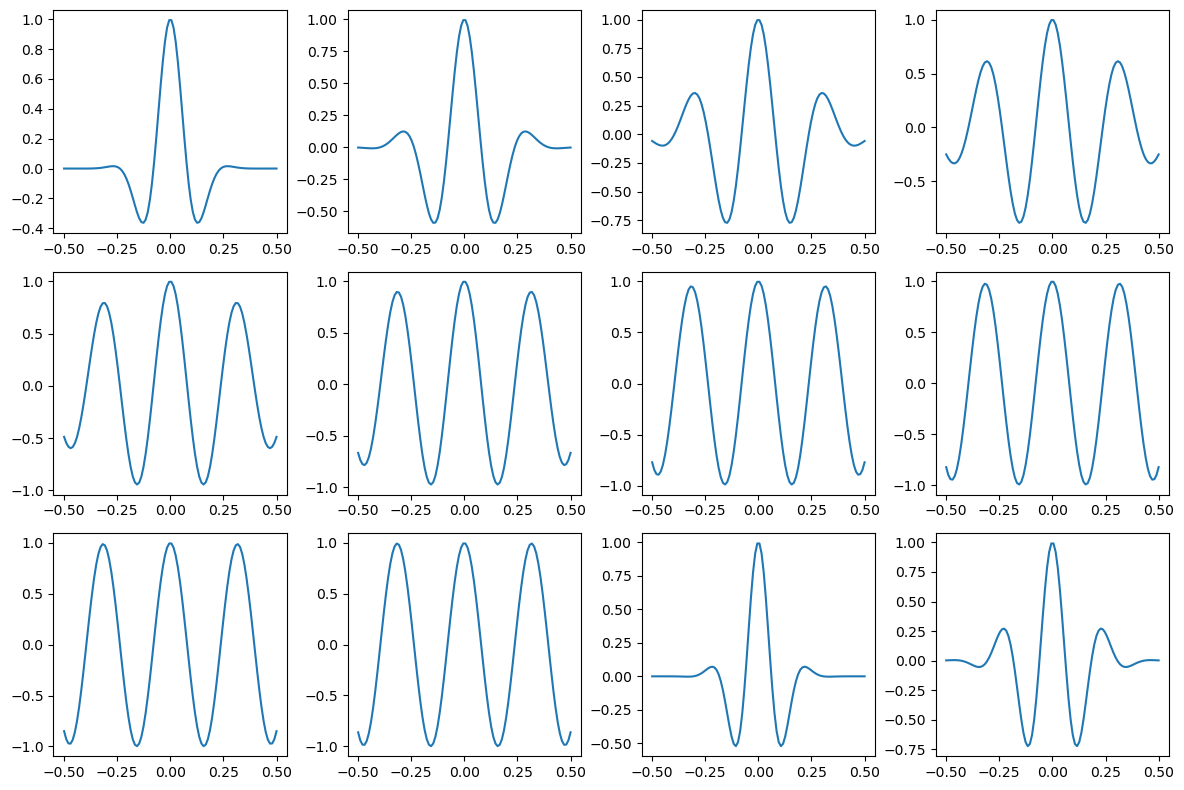

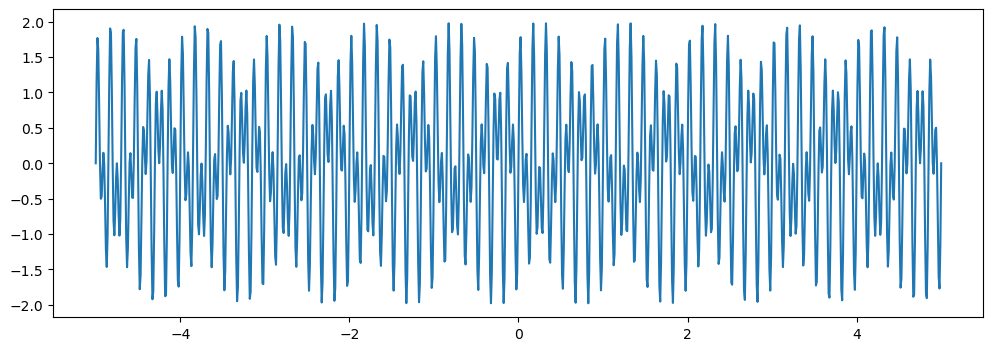

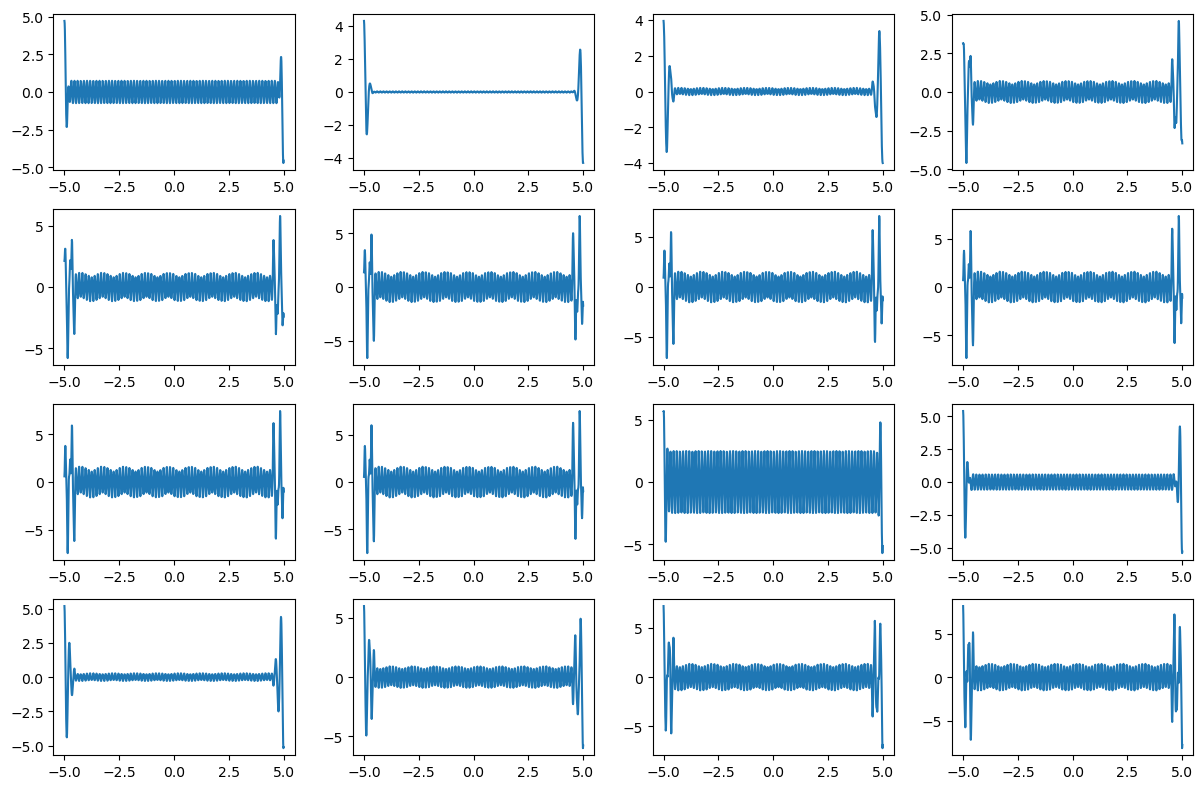

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
# Generate a sample signal
t = torch.linspace(-5, 5, 1000)
signal = torch.sin(2 * torch.pi * 7 * t) + torch.sin(2 * torch.pi * 13 * t)


def morlet_wavelet(t, width, freq):
    return torch.exp(-0.5 * (t / width) ** 2) * torch.cos(2 * math.pi * freq * t)

# Define a function to create a family of wavelets
def create_wavelet_family(t, widths, freqs):
    wavelets = []
    for freq in freqs:
        for width in widths:
            wavelet = morlet_wavelet(t, width, freq)
            wavelets.append(wavelet)
    wavelets = torch.stack(wavelets)
    return wavelets

kernel_t = torch.linspace(-0.5, 0.5, 100)
# Define scales for the wavelet family
scales = torch.logspace(-1, 0.5, 10) #torch.arange(1, 11).float()
# freqs = torch.arange(1, 10).float()
freqs = torch.logspace(0.5, 1.5, 10)
# Generate the wavelet family
wavelet_family = create_wavelet_family(kernel_t, scales, freqs=freqs)
wavelet_family = wavelet_family.unsqueeze(1)  # Add channel dimension

# Prepare the signal for convolution
signal = signal.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Perform grouped convolution
convolved_signals = F.conv1d(signal, wavelet_family, padding='same', )# groups=wavelet_family.size(0)

# Plot the wavelets in the family
figh, axs = plt.subplots(3, 4, figsize=(12, 8))
for ax, wavelet in zip(axs.flatten(), wavelet_family):
    ax.plot(kernel_t.numpy(), wavelet[0].detach().numpy())
    # plt.title(f'Scale {scales[i].item()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot (t.numpy(), signal.squeeze().numpy())
plt.show()

# Plot the original signal and the convolved signals
figh, axs = plt.subplots(4, 4, figsize=(12, 8))
for ax, convolved_signal in zip(axs.flatten(), convolved_signals[0]):
    ax.plot(t.numpy(), convolved_signal.detach().numpy())
    # plt.title(f'Scale {scales[i].item()}')

plt.tight_layout()
plt.show()

### Prepare SC09 dataset

https://paperswithcode.com/sota/speech-recognition-on-speech-commands-2

In [3]:
# Step 2: Load the SC09 dataset
from datasets import load_dataset
# Load the SC09 dataset
dataset = load_dataset("speech_commands", "v0.01")
# Step 3: Explore the dataset
# Check the dataset structure
print(dataset)
# Display some sample data
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 51093
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 6799
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 3081
    })
})
{'file': 'bed/4a294341_nohash_0.wav', 'audio': {'path': 'bed/4a294341_nohash_0.wav', 'array': array([0.00076294, 0.00296021, 0.00439453, ..., 0.00286865, 0.00283813,
       0.00216675]), 'sampling_rate': 16000}, 'label': 20, 'is_unknown': True, 'speaker_id': '4a294341', 'utterance_id': 0}


In [4]:
print(dataset['train'])

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 51093
})


In [25]:
dataset['train'].features['label']

['yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go',
 'zero',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'bed',
 'bird',
 'cat',
 'dog',
 'happy',
 'house',
 'marvin',
 'sheila',
 'tree',
 'wow',
 '_silence_']

In [9]:
dataset['train'][0]

{'file': 'bed/4a294341_nohash_0.wav',
 'audio': {'path': 'bed/4a294341_nohash_0.wav',
  'array': array([0.00076294, 0.00296021, 0.00439453, ..., 0.00286865, 0.00283813,
         0.00216675]),
  'sampling_rate': 16000},
 'label': 20,
 'is_unknown': True,
 'speaker_id': '4a294341',
 'utterance_id': 0}

In [11]:
list(dataset['train'][0].keys())

['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id']

In [14]:
dataset['train'][0]["audio"]["array"].shape

(16000,)

In [22]:
dataset['train'][0]["label"]

20

### HF wrapper of SC09

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset

# Step 1: Load the SC09 dataset
dataset = load_dataset("speech_commands", "v0.01")

# Step 2: Define a custom dataset class
class SC09Dataset(Dataset):
    def __init__(self, split):
        self.dataset = dataset[split]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio = item['audio']['array']
        label = item['label']
        return torch.tensor(audio, dtype=torch.float32), label

# Step 3: Create a DataLoader
def collate_fn(batch):
    audios, labels = zip(*batch)
    audios = torch.nn.utils.rnn.pad_sequence(audios, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return audios, labels

train_dataset = SC09Dataset(split='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Example of iterating through the DataLoader
for batch in train_loader:
    audios, labels = batch
    print(audios.shape, labels.shape)
    break

torch.Size([32, 16000]) torch.Size([32])


In [6]:
train_dataset = SC09Dataset(split='train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataset = SC09Dataset(split='test')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

### Train CNN on classification

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

In [40]:
tmp = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=64, padding=1, stride=8),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(32, 64, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(64, 128, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
)
tmp(torch.randn(32, 1, 16000)).shape

torch.Size([32, 128, 58])

In [37]:
model = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=64, padding=1, stride=8),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(32, 64, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(64, 128, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 31)
)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, num_epochs=20, lr=0.001):
    # Define loss function and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1)}')

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.unsqueeze(1)  # Add channel dimension
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Eval Accuracy: {accuracy}%')
    return accuracy

# Example usage:
# accuracy = train_and_evaluate(model, train_loader, test_loader, num_epochs=20, lr=0.001)

In [39]:
# Define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1)}')

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Epoch 1/20, Loss: 2.1483196631092603: 100%|██████████| 799/799 [01:09<00:00, 11.56it/s]


Epoch 1/20, Loss: 2.1483196631092603


Epoch 2/20, Loss: 1.1752783271189178: 100%|██████████| 799/799 [00:23<00:00, 33.33it/s]


Epoch 2/20, Loss: 1.1752783271189178


Epoch 3/20, Loss: 0.9052773353379122: 100%|██████████| 799/799 [00:23<00:00, 34.62it/s]


Epoch 3/20, Loss: 0.9052773353379122


Epoch 4/20, Loss: 0.7368506033146038: 100%|██████████| 799/799 [00:22<00:00, 34.93it/s]


Epoch 4/20, Loss: 0.7368506033146038


Epoch 5/20, Loss: 0.5944075173743825: 100%|██████████| 799/799 [00:23<00:00, 33.67it/s]


Epoch 5/20, Loss: 0.5944075173743825


Epoch 6/20, Loss: 0.49061710084409677: 100%|██████████| 799/799 [00:24<00:00, 33.16it/s]


Epoch 6/20, Loss: 0.49061710084409677


Epoch 7/20, Loss: 0.42060900302382376: 100%|██████████| 799/799 [00:23<00:00, 33.49it/s]


Epoch 7/20, Loss: 0.42060900302382376


Epoch 8/20, Loss: 0.36580075005603224: 100%|██████████| 799/799 [00:23<00:00, 33.42it/s]


Epoch 8/20, Loss: 0.36580075005603224


Epoch 9/20, Loss: 0.32433571331715855: 100%|██████████| 799/799 [00:24<00:00, 33.04it/s]


Epoch 9/20, Loss: 0.32433571331715855


Epoch 10/20, Loss: 0.29033835512936784: 100%|██████████| 799/799 [00:24<00:00, 32.97it/s]


Epoch 10/20, Loss: 0.29033835512936784


Epoch 11/20, Loss: 0.26491145374199776: 100%|██████████| 799/799 [00:24<00:00, 33.04it/s]


Epoch 11/20, Loss: 0.26491145374199776


Epoch 12/20, Loss: 0.24684147584544627: 100%|██████████| 799/799 [00:23<00:00, 33.50it/s]


Epoch 12/20, Loss: 0.24684147584544627


Epoch 13/20, Loss: 0.2291265635218504: 100%|██████████| 799/799 [00:23<00:00, 34.58it/s] 


Epoch 13/20, Loss: 0.2291265635218504


Epoch 14/20, Loss: 0.21296340064407887: 100%|██████████| 799/799 [00:24<00:00, 32.86it/s]


Epoch 14/20, Loss: 0.21296340064407887


Epoch 15/20, Loss: 0.18846875699108773: 100%|██████████| 799/799 [00:24<00:00, 32.96it/s]


Epoch 15/20, Loss: 0.18846875699108773


Epoch 16/20, Loss: 0.18955069918707665: 100%|██████████| 799/799 [00:24<00:00, 33.18it/s]


Epoch 16/20, Loss: 0.18955069918707665


Epoch 17/20, Loss: 0.17673663234918638: 100%|██████████| 799/799 [00:24<00:00, 33.09it/s]


Epoch 17/20, Loss: 0.17673663234918638


Epoch 18/20, Loss: 0.1675613615020774: 100%|██████████| 799/799 [00:24<00:00, 32.93it/s] 


Epoch 18/20, Loss: 0.1675613615020774


Epoch 19/20, Loss: 0.1553986833334081: 100%|██████████| 799/799 [00:24<00:00, 32.97it/s] 


Epoch 19/20, Loss: 0.1553986833334081


Epoch 20/20, Loss: 0.15228399586687807: 100%|██████████| 799/799 [00:24<00:00, 33.24it/s]


Epoch 20/20, Loss: 0.15228399586687807
Accuracy: 80.39597533268419%


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math 


class RBFLayer(nn.Module):
    def __init__(self, width=None,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, 
                 trainable_center=False,
                 trainable_width=False):
        super(RBFLayer, self).__init__()
        grid = torch.linspace(grid_min, grid_max, grid_size)
        self.centers = nn.Parameter(grid, requires_grad=trainable_center)
        if width is None:
            width = (grid_max - grid_min) / (grid_size - 1)
        self.width = nn.Parameter(torch.tensor(width, dtype=torch.float32), requires_grad=trainable_width)

    def forward(self, x):
        activations = torch.exp( - ((x[..., None] - self.centers) / self.width)**2)
        return activations


class RBFKANConvLayer(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 output_dim : int,
                 residual=True,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, width=None,
                 trainable_center=False,
                 trainable_width=False):
        super(RBFKANConvLayer, self).__init__()
        self.rbf = RBFLayer(width, grid_min, grid_max, grid_size, trainable_center, trainable_width)
        basis_coef = torch.randn(input_dim, grid_size) / math.sqrt(input_dim)
        self.basis_coef = nn.Parameter(basis_coef, requires_grad=True)
        self.residual = residual
        if residual:
            self.res_act = nn.SiLU()
        # self.readout = #nn.Linear(input_dim, output_dim)
        self.readout = nn.Conv1d(input_dim, output_dim, kernel_size=1)
        # self.basis_combined = nn.Linear(input_dim * grid_size, output_dim)
        

    def forward(self, x):
        rbf_act = self.rbf(x) # [batch_size, input_dim, grid_size]
        rbf_act = einops.einsum(rbf_act, self.basis_coef, 'B inp T grid, inp grid -> B inp T')
        if self.residual:
            rbf_act = rbf_act + self.res_act(x)
        out = self.readout(rbf_act)
        return out

In [17]:
modelKAN = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=64, padding=1, stride=8),
    # RBFKANConvLayer(32, 32, residual=True,),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(32, 64, kernel_size=16, padding=1, stride=2),
    RBFKANConvLayer(64, 64, residual=True,),
    nn.MaxPool1d(2),
    nn.Conv1d(64, 128, kernel_size=16, padding=1, stride=2),
    RBFKANConvLayer(128, 128, residual=True,),
    nn.MaxPool1d(2),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 31)
)

In [46]:
modelKAN(torch.randn(32, 1, 16000)).shape

torch.Size([32, 31])

In [18]:
acc = train_and_evaluate(modelKAN, train_loader, test_loader, num_epochs=30, lr=0.001)

Epoch 1/30, Loss: 3.4192409022101042:   7%|▋         | 57/799 [00:02<00:28, 26.48it/s]

In [12]:
acc = train_and_evaluate(modelKAN, train_loader, test_loader, num_epochs=20, lr=0.001)

Epoch 1/20, Loss: 2.049009181307314: 100%|██████████| 799/799 [00:34<00:00, 23.16it/s] 


Epoch 1/20, Loss: 2.049009181307314
Eval Accuracy: 57.74099318403116%


Epoch 2/20, Loss: 1.0105167894399212: 100%|██████████| 799/799 [00:31<00:00, 25.35it/s]


Epoch 2/20, Loss: 1.0105167894399212
Eval Accuracy: 66.4719246997728%


Epoch 3/20, Loss: 0.6608785792942787: 100%|██████████| 799/799 [00:32<00:00, 24.61it/s]


Epoch 3/20, Loss: 0.6608785792942787
Eval Accuracy: 74.35897435897436%


Epoch 4/20, Loss: 0.5172314722002374: 100%|██████████| 799/799 [00:32<00:00, 24.39it/s]


Epoch 4/20, Loss: 0.5172314722002374
Eval Accuracy: 78.44855566374554%


Epoch 5/20, Loss: 0.43600950411547706: 100%|██████████| 799/799 [00:32<00:00, 24.82it/s]


Epoch 5/20, Loss: 0.43600950411547706
Eval Accuracy: 78.64329763063941%


Epoch 6/20, Loss: 0.37721922084483994: 100%|██████████| 799/799 [00:31<00:00, 25.21it/s]


Epoch 6/20, Loss: 0.37721922084483994
Eval Accuracy: 77.37747484582927%


Epoch 7/20, Loss: 0.3328710583986269: 100%|██████████| 799/799 [00:32<00:00, 24.91it/s] 


Epoch 7/20, Loss: 0.3328710583986269
Eval Accuracy: 81.23985718922428%


Epoch 8/20, Loss: 0.31390534269533704: 100%|██████████| 799/799 [00:32<00:00, 24.61it/s]


Epoch 8/20, Loss: 0.31390534269533704
Eval Accuracy: 79.09769555339176%


Epoch 9/20, Loss: 0.28204904011309667: 100%|██████████| 799/799 [00:32<00:00, 24.34it/s]


Epoch 9/20, Loss: 0.28204904011309667
Eval Accuracy: 80.98020123336579%


Epoch 10/20, Loss: 0.2680706773862448: 100%|██████████| 799/799 [00:32<00:00, 24.64it/s] 


Epoch 10/20, Loss: 0.2680706773862448
Eval Accuracy: 81.62934112301201%


Epoch 11/20, Loss: 0.24842823698687763: 100%|██████████| 799/799 [00:32<00:00, 24.97it/s]


Epoch 11/20, Loss: 0.24842823698687763
Eval Accuracy: 82.31093800714054%


Epoch 12/20, Loss: 0.22723008904638742: 100%|██████████| 799/799 [00:32<00:00, 24.67it/s]


Epoch 12/20, Loss: 0.22723008904638742
Eval Accuracy: 82.24602401817592%


Epoch 13/20, Loss: 0.2154597687361312: 100%|██████████| 799/799 [00:32<00:00, 24.69it/s] 


Epoch 13/20, Loss: 0.2154597687361312
Eval Accuracy: 81.56442713404739%


Epoch 14/20, Loss: 0.20456987850890215: 100%|██████████| 799/799 [00:32<00:00, 24.66it/s]


Epoch 14/20, Loss: 0.20456987850890215
Eval Accuracy: 85.00486854917234%


Epoch 15/20, Loss: 0.1934496687086432: 100%|██████████| 799/799 [00:32<00:00, 24.73it/s] 


Epoch 15/20, Loss: 0.1934496687086432
Eval Accuracy: 83.99870172022071%


Epoch 16/20, Loss: 0.1935871467740276: 100%|██████████| 799/799 [00:32<00:00, 24.62it/s] 


Epoch 16/20, Loss: 0.1935871467740276
Eval Accuracy: 83.99870172022071%


Epoch 17/20, Loss: 0.16959290932490956: 100%|██████████| 799/799 [00:32<00:00, 24.70it/s]


Epoch 17/20, Loss: 0.16959290932490956
Eval Accuracy: 82.89516390782214%


Epoch 18/20, Loss: 0.1744373832002879: 100%|██████████| 799/799 [00:32<00:00, 24.67it/s] 


Epoch 18/20, Loss: 0.1744373832002879
Eval Accuracy: 82.89516390782214%


Epoch 19/20, Loss: 0.1624972209828592: 100%|██████████| 799/799 [00:31<00:00, 25.30it/s] 


Epoch 19/20, Loss: 0.1624972209828592
Eval Accuracy: 83.089905874716%


Epoch 20/20, Loss: 0.15913398326601885: 100%|██████████| 799/799 [00:32<00:00, 24.86it/s]


Epoch 20/20, Loss: 0.15913398326601885
Eval Accuracy: 83.0574488802337%


In [13]:
import torch.nn as nn

def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_trainable_parameters(modelKAN))
# Example usage:
# Assuming `model` is your PyTorch model
# num_params = count_trainable_parameters(model)
# print(f'The model has {num_params} trainable parameters.')

209215


In [14]:
model = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=64, padding=1, stride=8),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(32, 64, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(64, 128, kernel_size=16, padding=1, stride=2),
    nn.SiLU(),
    nn.MaxPool1d(2),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 31)
)

In [15]:

print(count_trainable_parameters(model))

186623


In [16]:
acc = train_and_evaluate(model, train_loader, test_loader, num_epochs=20, lr=0.001)

Epoch 1/20, Loss: 2.1694079964271324: 100%|██████████| 799/799 [00:24<00:00, 32.63it/s]


Epoch 1/20, Loss: 2.1694079964271324
Eval Accuracy: 51.41187925998052%


Epoch 2/20, Loss: 1.1897800228324193: 100%|██████████| 799/799 [00:24<00:00, 32.65it/s]


Epoch 2/20, Loss: 1.1897800228324193
Eval Accuracy: 64.45959104186953%


Epoch 3/20, Loss: 0.8451442840102319: 100%|██████████| 799/799 [00:24<00:00, 32.63it/s]


Epoch 3/20, Loss: 0.8451442840102319
Eval Accuracy: 70.20447906523856%


Epoch 4/20, Loss: 0.6357962385621925: 100%|██████████| 799/799 [00:24<00:00, 32.80it/s]


Epoch 4/20, Loss: 0.6357962385621925
Eval Accuracy: 74.39143135345667%


Epoch 5/20, Loss: 0.5232768390742649: 100%|██████████| 799/799 [00:24<00:00, 32.67it/s]


Epoch 5/20, Loss: 0.5232768390742649
Eval Accuracy: 75.49496916585524%


Epoch 6/20, Loss: 0.4481825133848548: 100%|██████████| 799/799 [00:24<00:00, 32.64it/s] 


Epoch 6/20, Loss: 0.4481825133848548
Eval Accuracy: 77.1502758844531%


Epoch 7/20, Loss: 0.3980363725832616: 100%|██████████| 799/799 [00:24<00:00, 32.66it/s] 


Epoch 7/20, Loss: 0.3980363725832616
Eval Accuracy: 76.95553391755924%


Epoch 8/20, Loss: 0.3547933635783285: 100%|██████████| 799/799 [00:24<00:00, 32.63it/s] 


Epoch 8/20, Loss: 0.3547933635783285
Eval Accuracy: 74.65108730931516%


Epoch 9/20, Loss: 0.32503278355798376: 100%|██████████| 799/799 [00:24<00:00, 32.65it/s]


Epoch 9/20, Loss: 0.32503278355798376
Eval Accuracy: 78.12398571892243%


Epoch 10/20, Loss: 0.2986491122964923: 100%|██████████| 799/799 [00:24<00:00, 32.64it/s] 


Epoch 10/20, Loss: 0.2986491122964923
Eval Accuracy: 79.03278156442714%


Epoch 11/20, Loss: 0.2761866703480296: 100%|██████████| 799/799 [00:24<00:00, 32.65it/s] 


Epoch 11/20, Loss: 0.2761866703480296
Eval Accuracy: 78.70821161960403%


Epoch 12/20, Loss: 0.2541557341529632: 100%|██████████| 799/799 [00:24<00:00, 32.66it/s] 


Epoch 12/20, Loss: 0.2541557341529632
Eval Accuracy: 79.51963648166179%


Epoch 13/20, Loss: 0.23670009800346012: 100%|██████████| 799/799 [00:24<00:00, 32.66it/s]


Epoch 13/20, Loss: 0.23670009800346012
Eval Accuracy: 80.29860434923727%


Epoch 14/20, Loss: 0.22249749968194393: 100%|██████████| 799/799 [00:24<00:00, 32.66it/s]


Epoch 14/20, Loss: 0.22249749968194393
Eval Accuracy: 80.29860434923727%


Epoch 15/20, Loss: 0.20888322753568317: 100%|██████████| 799/799 [00:24<00:00, 32.63it/s]


Epoch 15/20, Loss: 0.20888322753568317
Eval Accuracy: 79.74683544303798%


Epoch 16/20, Loss: 0.19891446417381753: 100%|██████████| 799/799 [00:24<00:00, 32.84it/s]


Epoch 16/20, Loss: 0.19891446417381753
Eval Accuracy: 80.88283024991885%


Epoch 17/20, Loss: 0.18193511371716428: 100%|██████████| 799/799 [00:24<00:00, 32.64it/s]


Epoch 17/20, Loss: 0.18193511371716428
Eval Accuracy: 80.688088283025%


Epoch 18/20, Loss: 0.1738789113907514: 100%|██████████| 799/799 [00:24<00:00, 32.68it/s] 


Epoch 18/20, Loss: 0.1738789113907514
Eval Accuracy: 80.1038623823434%


Epoch 19/20, Loss: 0.17779314693282633: 100%|██████████| 799/799 [00:24<00:00, 32.71it/s]


Epoch 19/20, Loss: 0.17779314693282633
Eval Accuracy: 78.83803959753327%


Epoch 20/20, Loss: 0.16102059703385538: 100%|██████████| 799/799 [00:24<00:00, 32.67it/s]


Epoch 20/20, Loss: 0.16102059703385538
Eval Accuracy: 80.4284323271665%
